In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
)
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Cargar los datos
data_path = r'D:\Jhonatan\Nueva carpeta\CIC-IDS-20177-PAQUET'
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.parquet')]
df = pd.concat((pd.read_parquet(f) for f in all_files), ignore_index=True)


In [ ]:
# Preprocesamiento
df.drop_duplicates(inplace=True)
df['Label'] = np.where(df['Label'] == 'Benign', 0, 1)

C:\Users\user\AppData\Local\Temp\ipykernel_9864\1886784938.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Label'], palette='Set1')


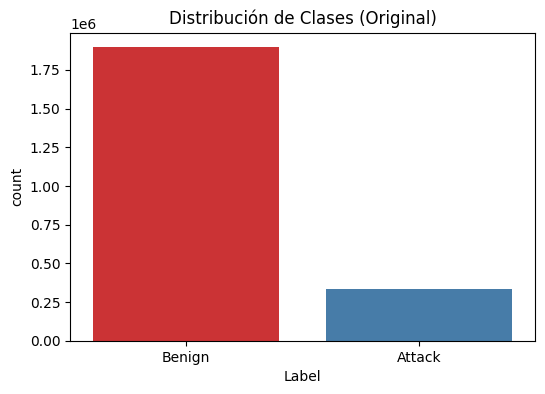

In [ ]:
# Visualización de clases originales
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Label'], palette='Set1')
plt.title('Distribución de Clases (Original)')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()

In [ ]:
# Submuestreo para pruebas más rápidas
df_sampled = df.sample(frac=0.25, random_state=42)
X = df_sampled.drop('Label', axis=1).astype(np.float32)
y = df_sampled['Label']

In [ ]:

# Balanceo con BorderlineSMOTE + Undersampling
smote = BorderlineSMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_res, y_res)

C:\Users\user\AppData\Local\Temp\ipykernel_9864\3782777528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res, palette='Set1')


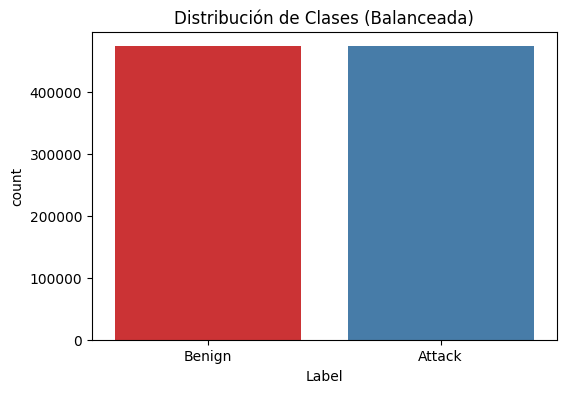

In [ ]:
# Visualización después del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res, palette='Set1')
plt.title('Distribución de Clases (Balanceada)')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()


In [ ]:

# División Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Conversión a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# Dataset personalizado
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TabularDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TabularDataset(X_val_tensor, y_val_tensor), batch_size=128)
test_loader = DataLoader(TabularDataset(X_test_tensor, y_test_tensor), batch_size=128)


In [ ]:
# Modelo TabTransformer
class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x.unsqueeze(1))
        x = x.mean(dim=1)
        return self.classifier(x)



In [ ]:
# Inicialización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabTransformer(input_dim=X_train_tensor.shape[1], num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., 5.], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Entrenamiento con validación
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
epochs = 10

In [43]:
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.2f}% - Val Acc: {val_acc:.2f}%")


Epoch 1/10 - Train Acc: 96.78% - Val Acc: 97.27%
Epoch 2/10 - Train Acc: 96.83% - Val Acc: 96.67%
Epoch 3/10 - Train Acc: 96.99% - Val Acc: 96.39%
Epoch 4/10 - Train Acc: 97.03% - Val Acc: 97.31%
Epoch 5/10 - Train Acc: 97.13% - Val Acc: 97.09%
Epoch 6/10 - Train Acc: 97.24% - Val Acc: 97.52%
Epoch 7/10 - Train Acc: 97.30% - Val Acc: 97.57%
Epoch 8/10 - Train Acc: 97.35% - Val Acc: 97.16%
Epoch 9/10 - Train Acc: 97.44% - Val Acc: 97.47%
Epoch 10/10 - Train Acc: 97.40% - Val Acc: 97.09%


In [ ]:
# Evaluación
model.eval()
preds, labels, probs = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs_batch = torch.softmax(outputs, dim=1)[:, 1]
        preds_batch = torch.argmax(outputs, dim=1)
        preds.extend(preds_batch.cpu().numpy())
        probs.extend(probs_batch.cpu().numpy())
        labels.extend(y_batch.numpy())

In [45]:
print("\n🔍 Evaluación en test:")
print("Accuracy:", accuracy_score(labels, preds))
print("Precision:", precision_score(labels, preds))
print("Recall:", recall_score(labels, preds))
print("F1 Score:", f1_score(labels, preds))
print("MCC:", matthews_corrcoef(labels, preds))
print("AUC-ROC:", roc_auc_score(labels, probs))


🔍 Evaluación en test:
Accuracy: 0.9708708497467642
Precision: 0.9461588706559847
Recall: 0.998564997186269
F1 Score: 0.9716558177101515
MCC: 0.9431895991715731
AUC-ROC: 0.9960100534276373


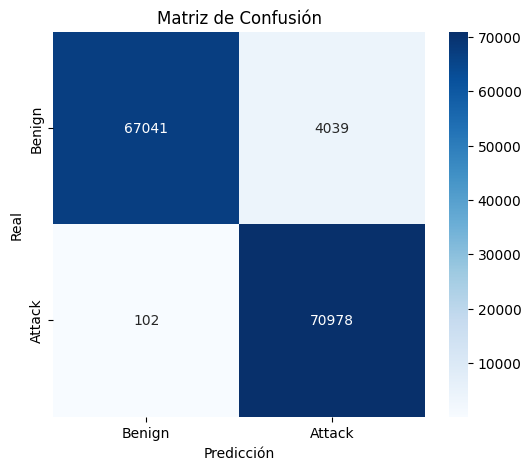

In [ ]:
# Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

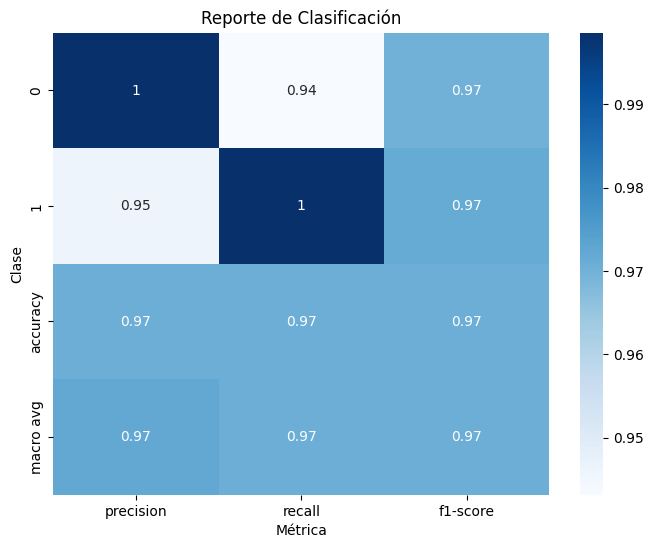

In [ ]:
# Classification Report Heatmap
report = classification_report(labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='Blues')
plt.title("Reporte de Clasificación")
plt.xlabel("Métrica")
plt.ylabel("Clase")
plt.show()

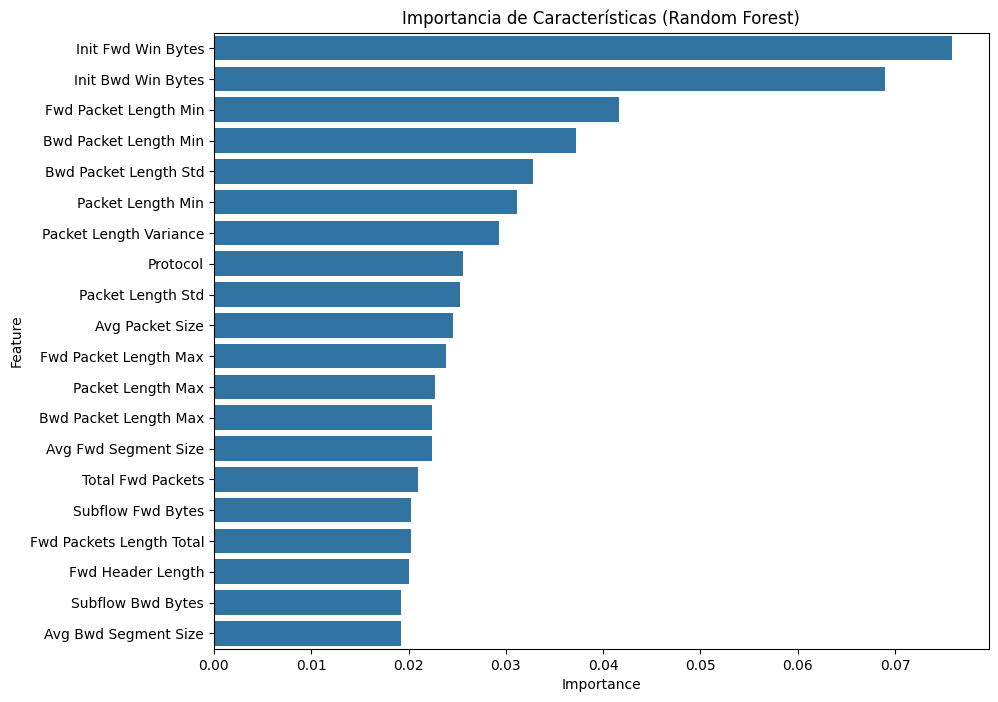

In [ ]:
# Feature Importance con Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), y='Feature', x='Importance')
plt.title("Importancia de Características (Random Forest)")
plt.show()

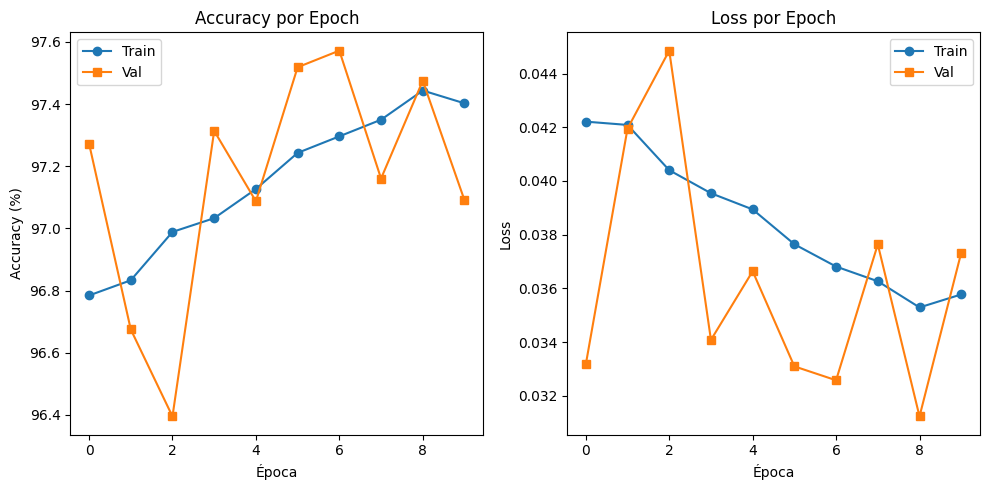

In [ ]:
# Gráfica de Accuracy y Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train', marker='o')
plt.plot(val_accuracies, label='Val', marker='s')
plt.title('Accuracy por Epoch')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train', marker='o')
plt.plot(val_losses, label='Val', marker='s')
plt.title('Loss por Epoch')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Mostrar predicciones de algunas muestras del conjunto de prueba
num_muestras = 10000
print("\n🔍 Ejemplos individuales de predicción:")

for i in range(num_muestras):
    X_sample = X_test_tensor[i].unsqueeze(0).to(device)  # Añadir dimensión batch
    y_true = y_test_tensor[i].item()
    model.eval()
    with torch.no_grad():
        output = model(X_sample)
        prob = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred = np.argmax(prob)
    
    print(f"Muestra {i+1}:")
    print(f"   ➤ Etiqueta real    : {'Attack' if y_true == 1 else 'Benign'}")
    print(f"   ➤ Predicción       : {'Attack' if pred == 1 else 'Benign'}")
    print(f"   ➤ Confianza ataque : {prob[1]:.4f}")
    print(f"   {'✔️ Correcto' if pred == y_true else '❌ Incorrecto'}")



🔍 Ejemplos individuales de predicción:
Muestra 1:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9999
   ✔️ Correcto
Muestra 2:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9999
   ✔️ Correcto
Muestra 3:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9976
   ✔️ Correcto
Muestra 4:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9998
   ✔️ Correcto
Muestra 5:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9930
   ✔️ Correcto
Muestra 6:
   ➤ Etiqueta real    : Benign
   ➤ Predicción       : Benign
   ➤ Confianza ataque : 0.0000
   ✔️ Correcto
Muestra 7:
   ➤ Etiqueta real    : Attack
   ➤ Predicción       : Attack
   ➤ Confianza ataque : 0.9999
   ✔️ Correcto
Muestra 8:
   ➤ Etiqueta real    : Benign
   ➤ Predicción       : Benign
   ➤ Confianza ataque : 0.0000
   ✔️ Correcto
Muestra 

In [ ]:
# Ver ejemplos donde el modelo falla
print("\n🔍 Mostrando los primeros errores del modelo:")

errores = []
model.eval()
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        X_sample = X_test_tensor[i].unsqueeze(0).to(device)
        y_true = y_test_tensor[i].item()
        output = model(X_sample)
        pred = torch.argmax(output, dim=1).item()
        if pred != y_true:
            errores.append((i, y_true, pred))
        if len(errores) >= 10:
            break

for idx, real, pred in errores:
    print(f"Muestra {idx} - Real: {'Attack' if real == 1 else 'Benign'}, Predicho: {'Attack' if pred == 1 else 'Benign'} ❌")



🔍 Mostrando los primeros errores del modelo:
Muestra 8 - Real: Benign, Predicho: Attack ❌
Muestra 16 - Real: Benign, Predicho: Attack ❌
Muestra 25 - Real: Benign, Predicho: Attack ❌
Muestra 48 - Real: Benign, Predicho: Attack ❌
Muestra 75 - Real: Benign, Predicho: Attack ❌
Muestra 77 - Real: Benign, Predicho: Attack ❌
Muestra 223 - Real: Benign, Predicho: Attack ❌
Muestra 275 - Real: Benign, Predicho: Attack ❌
Muestra 276 - Real: Benign, Predicho: Attack ❌
Muestra 314 - Real: Benign, Predicho: Attack ❌


In [53]:
cm = confusion_matrix(labels, preds)
print("\n📊 Matriz de Confusión (números):")
print(f"   Verdaderos Negativos (Benign → Benign): {cm[0][0]}")
print(f"   Falsos Positivos  (Benign → Attack):  {cm[0][1]}")
print(f"   Falsos Negativos  (Attack → Benign):  {cm[1][0]}")
print(f"   Verdaderos Positivos (Attack → Attack): {cm[1][1]}")



📊 Matriz de Confusión (números):
   Verdaderos Negativos (Benign → Benign): 67041
   Falsos Positivos  (Benign → Attack):  4039
   Falsos Negativos  (Attack → Benign):  102
   Verdaderos Positivos (Attack → Attack): 70978
